# Hackathon Task:
# A/B Test Analysis for Foodtech Company

## Project Overview

A UK-based foodtech company conducting food delivery has recently run an A/B test to improve user experience and conversion rates. The goal of the test was to determine if displaying larger food images on restaurant menu cards leads to higher order rates b helping users better understand how meals look.

Hypothesis: increasing the size of food images on restaurant menu cards will improve conversion to orders

User Split: Users were randomly assigned to either the control group (original design) or the test group (larger food images)

Key UI Difference: The control group saw the original smaller images, while the test group saw larger food images

Hackhaton Task:
1. Evaluate the A/B Test design - Assess the experiment's methodology and suggest improvements
2. Analyze the dataset - Extract insights about user behaviour and test results
3. Draw conclusions & make business recommendations - provide data-driven advice on the next steps for the product team

## Full Code

### Data Validation

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportion_confint

In [2]:
#load data
df = pd.read_csv('DATASET.csv')
df.head()

,event_id,session_id,user_id,variation,platform,datetime_event,event_type,final_order_status,shop_id
0,63527610,6391574,762832,2,Android,2024-11-30 16:23:46.391133804,entry_to_shop,successful,8531.0
1,12446736,6391574,762832,2,Android,2024-11-30 16:26:16.875713965,order_paid,successful,8531.0
2,90232698,6391574,762832,2,Android,2024-11-30 16:50:44.827088753,order_finished,successful,8531.0
3,74183469,9246026,762832,2,Android,2024-11-29 13:21:28.729203894,reload_the_page,NaN,6186.0
4,16360628,9246026,762832,2,Android,2024-11-29 13:21:35.213637901,entry_to_shop,NaN,6186.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326921 entries, 0 to 326920
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   event_id            326921 non-null  int64  
 1   session_id          326921 non-null  int64  
 2   user_id             326921 non-null  int64  
 3   variation           326921 non-null  int64  
 4   platform            326921 non-null  object 
 5   datetime_event      326921 non-null  object 
 6   event_type          326921 non-null  object 
 7   final_order_status  170632 non-null  object 
 8   shop_id             315842 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 22.4+ MB


Data consists of 326921 records with 9 features. Datetime column is object type and it is recorded to the milisecond. To simplify the analysis, we change the time only to the second and the data type to datetime.

In [4]:
df['datetime_event'] = pd.to_datetime(df['datetime_event']).dt.floor('s')
df.head()

,event_id,session_id,user_id,variation,platform,datetime_event,event_type,final_order_status,shop_id
0,63527610,6391574,762832,2,Android,2024-11-30 16:23:46,entry_to_shop,successful,8531.0
1,12446736,6391574,762832,2,Android,2024-11-30 16:26:16,order_paid,successful,8531.0
2,90232698,6391574,762832,2,Android,2024-11-30 16:50:44,order_finished,successful,8531.0
3,74183469,9246026,762832,2,Android,2024-11-29 13:21:28,reload_the_page,NaN,6186.0
4,16360628,9246026,762832,2,Android,2024-11-29 13:21:35,entry_to_shop,NaN,6186.0


There are null values on column final order status and shop id. Also, based on the readme files, there is reload_the_page event which is when the user updated the list of the restaurant. Since it doesn't really affect the conversion rate, we remove records with this event.

In [5]:
#check event type reload the page
df[df['event_type'] == 'reload_the_page']

,event_id,session_id,user_id,variation,platform,datetime_event,event_type,final_order_status,shop_id
3,74183469,9246026,762832,2,Android,2024-11-29 13:21:28,reload_the_page,NaN,6186.0
10,70555348,9301426,762832,2,Android,2024-11-27 21:49:39,reload_the_page,NaN,7777.0
13,55935404,8603916,892078,2,Android,2024-11-29 18:15:53,reload_the_page,NaN,NaN
37,80422890,4323123,190143,1,Android,2024-11-26 18:07:22,reload_the_page,NaN,5769.0
46,32563107,7375318,389871,2,Android,2024-11-29 20:24:48,reload_the_page,NaN,4431.0
...,...,...,...,...,...,...,...,...,...
326888,64976794,2703343,492522,1,iOS,2024-11-27 17:17:29,reload_the_page,NaN,4425.0
326890,72680307,9494800,492522,1,iOS,2024-11-30 15:49:59,reload_the_page,NaN,NaN
326892,99080554,6701320,243041,1,iOS,2024-11-28 14:04:08,reload_the_page,successful,3468.0
326910,66965683,5212144,586714,1,Android,2024-11-29 21:56:26,reload_the_page,NaN,NaN


In [6]:
df.drop(df[df['event_type'] == 'reload_the_page'].index, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 273051 entries, 0 to 326920
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   event_id            273051 non-null  int64         
 1   session_id          273051 non-null  int64         
 2   user_id             273051 non-null  int64         
 3   variation           273051 non-null  int64         
 4   platform            273051 non-null  object        
 5   datetime_event      273051 non-null  datetime64[ns]
 6   event_type          273051 non-null  object        
 7   final_order_status  157254 non-null  object        
 8   shop_id             273051 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 20.8+ MB


After dropping reload_the_page event, there are no more missing values on shop_id column. We look further into missing values on final order status

In [7]:
#check final_order_status values
df['final_order_status'].unique()

array(['successful', nan, 'cancelled', 'refunded_after_delivery'],
      dtype=object)

In [8]:
df[df['final_order_status'].isna() == True]

,event_id,session_id,user_id,variation,platform,datetime_event,event_type,final_order_status,shop_id
4,16360628,9246026,762832,2,Android,2024-11-29 13:21:35,entry_to_shop,NaN,6186.0
5,87975585,9457939,762832,2,Android,2024-11-28 23:59:24,entry_to_shop,NaN,6742.0
9,15277830,2243403,762832,2,Android,2024-11-27 19:15:36,entry_to_shop,NaN,1331.0
11,59360337,9301426,762832,2,Android,2024-11-27 21:49:46,entry_to_shop,NaN,7777.0
12,89834024,5541689,892078,2,Android,2024-11-29 19:41:01,entry_to_shop,NaN,2021.0
...,...,...,...,...,...,...,...,...,...
326902,45224791,9833317,174104,1,Android,2024-11-29 17:01:04,entry_to_shop,NaN,5749.0
326903,17147329,1213680,159768,2,Android,2024-11-29 18:38:57,entry_to_shop,NaN,8863.0
326914,99343440,6071845,586714,1,Android,2024-11-28 17:52:55,entry_to_shop,NaN,9871.0
326915,46112455,3371713,399051,1,Android,2024-11-28 17:35:26,entry_to_shop,NaN,8777.0


In [9]:
#check what event type with nan status
df[df['final_order_status'].isna() == True]['event_type'].unique()

array(['entry_to_shop'], dtype=object)

Final_order_status values only missing on entry to shop event. We further look into this.

In [10]:
#check all event type
df['event_type'].unique()

array(['entry_to_shop', 'order_paid', 'order_finished'], dtype=object)

Looking at the event types, we could say that the order status are missing because the customer saw the product and decided not to buy. But this could collide with the cancelled status. We take a look at order with cancelled status

In [11]:
#check order with cancelled status
df[df['final_order_status'] == 'cancelled']

,event_id,session_id,user_id,variation,platform,datetime_event,event_type,final_order_status,shop_id
34,78363104,3538169,656956,1,iOS,2024-11-28 17:08:35,entry_to_shop,cancelled,7076.0
35,35545979,3538169,656956,1,iOS,2024-11-28 17:14:05,order_paid,cancelled,7076.0
36,82457777,3538169,656956,1,iOS,2024-11-28 18:00:12,order_finished,cancelled,7076.0
39,76458468,3474404,190143,1,Android,2024-11-30 20:15:29,entry_to_shop,cancelled,2151.0
40,48205930,3474404,190143,1,Android,2024-11-30 20:25:53,order_paid,cancelled,2151.0
...,...,...,...,...,...,...,...,...,...
326884,65776574,1805888,309629,1,iOS,2024-11-29 17:14:19,order_paid,cancelled,9519.0
326885,35352597,1805888,309629,1,iOS,2024-11-29 17:43:56,order_finished,cancelled,9519.0
326911,26849561,5243618,586714,1,Android,2024-11-26 21:31:08,entry_to_shop,cancelled,2666.0
326912,38498933,5243618,586714,1,Android,2024-11-26 21:35:17,order_paid,cancelled,2666.0


It looks like the status cancelled is when customer decided to cancel the order when they finished their order. We further make sure of this by checking the count of each session id with cancelled order. They should only have 3 sessions, because the customer did all the process and canceled at the end.

In [12]:
#check the count of every session_id
group = df[df['final_order_status'] == 'cancelled'].groupby('session_id')['event_id'].count().reset_index()
group

,session_id,event_id
0,1000867,3
1,1002655,3
2,1004470,3
3,1007064,3
4,1011199,3
...,...,...
5296,9992929,3
5297,9993754,3
5298,9994997,3
5299,9996957,3


In [13]:
#check if there is session id with less than 3 session
group[group['event_id'] < 3]

,session_id,event_id


All session has the status cancelled when the customer already finished their order and cancel afterwards. We could say in a way that it is a successful conversion to orders but it is also a failed conversion to revenue.

We can conclude that session with missing values on final order status are failed conversion, so we keep them in the data. For the cancelled order, we consider it as a failed conversion, because even though the order conversion is supposed to be successful, there is no revenue due to cancellation. 

There is one more final order status, that is refunded after delivery, that we have to check.

In [14]:
df[df['final_order_status']=='refunded_after_delivery']

,event_id,session_id,user_id,variation,platform,datetime_event,event_type,final_order_status,shop_id
102,51968013,8154645,815764,1,Android,2024-11-27 20:03:37,entry_to_shop,refunded_after_delivery,8570.0
103,87871499,8154645,815764,1,Android,2024-11-27 20:08:33,order_paid,refunded_after_delivery,8570.0
104,31178040,8154645,815764,1,Android,2024-11-27 21:19:39,order_finished,refunded_after_delivery,8570.0
227,70088923,8709728,552738,1,Android,2024-11-28 18:23:57,entry_to_shop,refunded_after_delivery,2776.0
228,34135377,8709728,552738,1,Android,2024-11-28 18:28:06,order_paid,refunded_after_delivery,2776.0
...,...,...,...,...,...,...,...,...,...
326694,14547496,6717208,976657,1,Android,2024-11-26 16:46:14,order_paid,refunded_after_delivery,3879.0
326695,61892450,6717208,976657,1,Android,2024-11-26 17:11:37,order_finished,refunded_after_delivery,3879.0
326837,35831280,8130204,717745,1,iOS,2024-11-29 17:40:25,entry_to_shop,refunded_after_delivery,8242.0
326838,70163305,8130204,717745,1,iOS,2024-11-29 17:45:22,order_paid,refunded_after_delivery,8242.0


Looking at the data, it can be infer that it is similar with cancelled status, with the difference being the order is cancelled after it is already in delivery. We are treating this status like the cancelled status, which is assign it as failed conversion

Before exploring the data, we first reduce the number of duplicates data by only keeping only one record for each session_id. Since the final_order_status for every session can be identified just from the first event (entry to shop) we can remove the duplicates.

In [15]:
#delete duplicate sessions
data = df.drop_duplicates('session_id', keep='first')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168215 entries, 0 to 326920
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   event_id            168215 non-null  int64         
 1   session_id          168215 non-null  int64         
 2   user_id             168215 non-null  int64         
 3   variation           168215 non-null  int64         
 4   platform            168215 non-null  object        
 5   datetime_event      168215 non-null  datetime64[ns]
 6   event_type          168215 non-null  object        
 7   final_order_status  52418 non-null   object        
 8   shop_id             168215 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 12.8+ MB


After dropping duplicates, we are left with 168215 records. Next, we want to assign each record with success and failed conversion based on the order status. As mentioned before, we consider the blank, cancelled, and refunded status as failed conversion

### Data Exploration

To make the calculation easier, success conversion is labeled as 1 and failed conversion as 0. We also fill NaN final order status as cust_left.

In [16]:
#copy the data
data_1 = data.copy(deep=True)

#add conversion status
data_1['conversion'] = data_1['final_order_status'].apply(lambda x : 1 if x == 'successful' else 0)
data_1 = data_1.fillna('cust_left')
data_1.head()

,event_id,session_id,user_id,variation,platform,datetime_event,event_type,final_order_status,shop_id,conversion
0,63527610,6391574,762832,2,Android,2024-11-30 16:23:46,entry_to_shop,successful,8531.0,1
4,16360628,9246026,762832,2,Android,2024-11-29 13:21:35,entry_to_shop,cust_left,6186.0,0
5,87975585,9457939,762832,2,Android,2024-11-28 23:59:24,entry_to_shop,cust_left,6742.0,0
6,79159985,9929810,762832,2,Android,2024-11-28 17:42:49,entry_to_shop,successful,9082.0,1
9,15277830,2243403,762832,2,Android,2024-11-27 19:15:36,entry_to_shop,cust_left,1331.0,0


First, we can see the number of records for each order status.

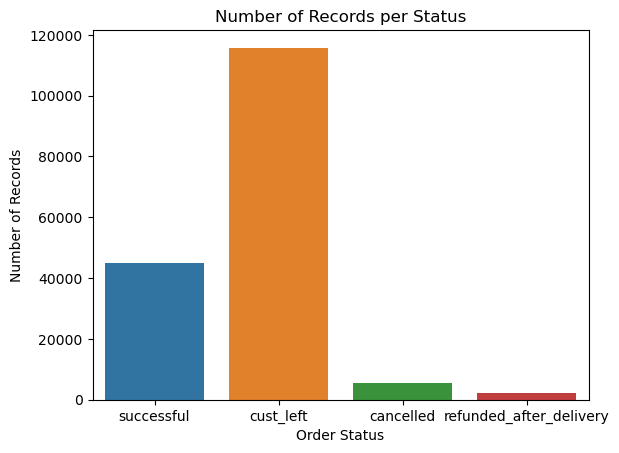

In [17]:
sns.countplot(data=data_1, x='final_order_status')
plt.title('Number of Records per Status')
plt.xlabel('Order Status')
plt.ylabel('Number of Records')
plt.show()

We can infer that the number of failed conversion are higher than the success conversion. Most of the failed conversion are due to customer left after entering a shop, and only a few caused by cancellation or refund. 

Now, we want to see the conversion overview of both variation.

In [65]:
#group data by variation, calculate total records and conversions
group = data_1.groupby('variation').agg(
    total_record = ('event_id', 'count'),
    total_conversion = ('conversion', 'sum')
).reset_index()

group['conversion_rate'] = group['total_conversion'] / group['total_record']
group

,variation,total_record,total_conversion,conversion_rate
0,1,109325,28661,0.262163
1,2,58890,16197,0.275038


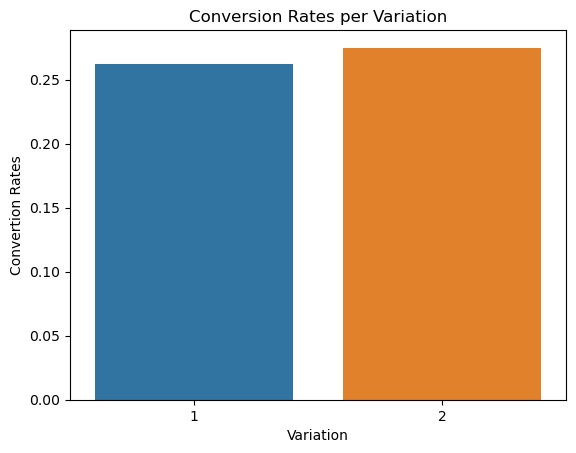

In [68]:
#visualize the conversion rate
sns.barplot(data=group, x='variation', y='conversion_rate')
plt.title('Conversion Rates per Variation')
plt.xlabel('Variation')
plt.ylabel('Conversion Rates')
plt.show()

On this data, variation 1 has roughly two times more records than variation 2. However, they both have pretty similar conversion rates, with variation 2 a bit higher. Next, we want to see the conversion rates of each platform.

In [19]:
#group data by platform
group = data_1.groupby('platform').agg(
    total_record = ('event_id', 'count'),
    total_conversion = ('conversion', 'sum')
)

group['conversion_rate'] = group['total_conversion'] / group['total_record']
group

,total_record,total_conversion,conversion_rate
platform,,,
Android,117696,30180,0.256423
iOS,50519,14678,0.290544


In [69]:
#group data by platform and variation
group = data_1.groupby(['platform','variation']).agg(
    total_record = ('event_id', 'count'),
    total_conversion = ('conversion', 'sum')
).reset_index()

group['conversion_rate'] = group['total_conversion'] / group['total_record']
group

,platform,variation,total_record,total_conversion,conversion_rate
0,Android,1,76377,19309,0.252812
1,Android,2,41319,10871,0.263099
2,iOS,1,32948,9352,0.283841
3,iOS,2,17571,5326,0.303113


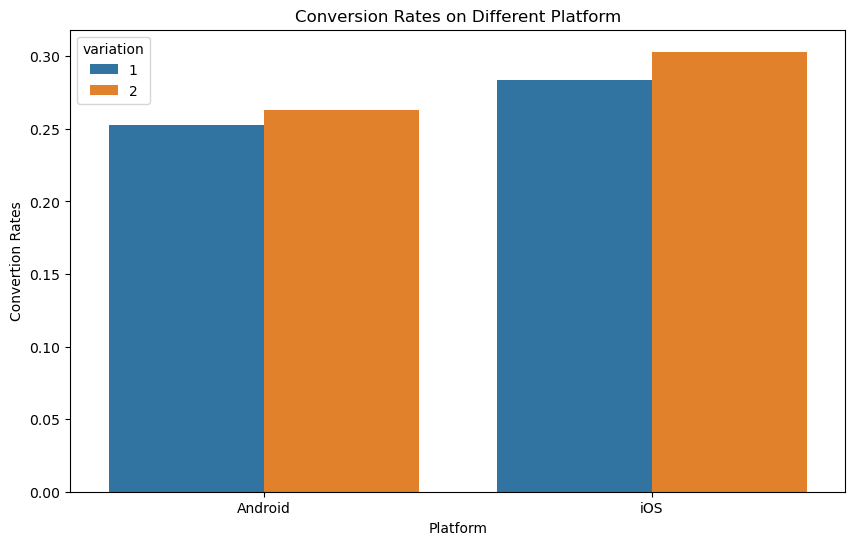

In [72]:
#visualize the conversion rate
plt.figure(figsize=(10, 6))
sns.barplot(data=group, x='platform', y='conversion_rate', hue='variation', dodge=True)
plt.title('Conversion Rates on Different Platform')
plt.xlabel('Platform')
plt.ylabel('Conversion Rates')
plt.show()

There are more Android users than iOS. The conversion rate on iOS platform is higher than on Android, but variation 2 is still higher than variation 2 on each platform.

Next, we want to see if the time in a day can affect the conversion rates.

In [21]:
#add hour column to data
data_1['hour'] = data_1['datetime_event'].dt.hour
data_1.head()

,event_id,session_id,user_id,variation,platform,datetime_event,event_type,final_order_status,shop_id,conversion,hour
0,63527610,6391574,762832,2,Android,2024-11-30 16:23:46,entry_to_shop,successful,8531.0,1,16
4,16360628,9246026,762832,2,Android,2024-11-29 13:21:35,entry_to_shop,cust_left,6186.0,0,13
5,87975585,9457939,762832,2,Android,2024-11-28 23:59:24,entry_to_shop,cust_left,6742.0,0,23
6,79159985,9929810,762832,2,Android,2024-11-28 17:42:49,entry_to_shop,successful,9082.0,1,17
9,15277830,2243403,762832,2,Android,2024-11-27 19:15:36,entry_to_shop,cust_left,1331.0,0,19


In [73]:
#group data by hour, calculate total records and conversions
group = data_1.groupby('hour').agg(
    total_record = ('event_id', 'count'),
    total_conversion = ('conversion', 'sum')
).reset_index()

group['conversion_rate'] = group['total_conversion'] / group['total_record']
group

,hour,total_record,total_conversion,conversion_rate
0,7,4,2,0.500000
1,8,21,7,0.333333
2,9,58,21,0.362069
3,10,219,55,0.251142
4,11,678,188,0.277286
5,12,1774,478,0.269448
6,13,3994,1013,0.253630
7,14,7901,2144,0.271358
8,15,13649,3710,0.271815
9,16,20058,5366,0.267524


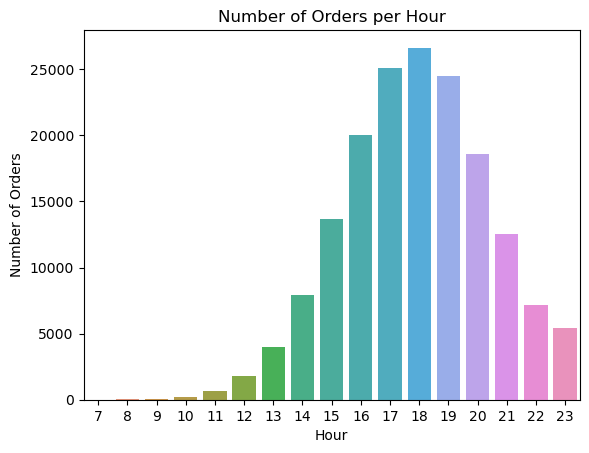

In [74]:
#make bar plot to see clearer
sns.barplot(data=group, x='hour', y='total_record')
plt.title('Number of Orders per Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Orders')
plt.show()

We can see that the conversion rates are pretty similar every hour. The rates in the morning are higher but they don't have that much records. It seems that the time with most customers are around afternoon to evening, starting from 3 pm and subsiding at 9 pm, with peak at 6 pm. We could say that customers start buying food after they get off from work.

We want to see if the conversion rates are different in this peak hours.

In [78]:
#group data by platform and variation
group = data_1[(data_1.hour > 15) & (data_1.hour < 21)].groupby(['hour','variation']).agg(
    total_record = ('event_id', 'count'),
    total_conversion = ('conversion', 'sum')
).reset_index()

group['conversion_rate'] = group['total_conversion'] / group['total_record']
group

,hour,variation,total_record,total_conversion,conversion_rate
0,16,1,13033,3457,0.265250
1,16,2,7025,1909,0.271744
2,17,1,16259,4156,0.255612
3,17,2,8813,2464,0.279587
4,18,1,17354,4612,0.265760
5,18,2,9273,2524,0.272188
6,19,1,15902,4204,0.264369
7,19,2,8582,2350,0.273829
8,20,1,12034,3169,0.263337
9,20,2,6525,1794,0.274943


Just like before, the conversion rates also pretty similar across both variations. Next, we want to see if there are certain shops that have higher rate than others.

In [26]:
#group data by platform and variation
group = data_1.groupby(['shop_id']).agg(
    total_record = ('event_id', 'count'),
    total_conversion = ('conversion', 'sum')
).reset_index()

group['conversion_rate'] = group['total_conversion'] / group['total_record']
group = group.sort_values('conversion_rate', ascending=False)
group

,shop_id,total_record,total_conversion,conversion_rate
506,5478.0,176,67,0.380682
121,2002.0,171,65,0.380117
199,2641.0,151,56,0.370861
902,9088.0,165,59,0.357576
944,9442.0,152,54,0.355263
...,...,...,...,...
931,9316.0,158,29,0.183544
456,4990.0,165,30,0.181818
477,5228.0,143,26,0.181818
881,8857.0,177,31,0.175141


In [27]:
#shop rates statistic
group.conversion_rate.describe()

count    1000.000000
mean        0.266757
std         0.033815
min         0.162651
25%         0.243902
50%         0.267479
75%         0.289195
max         0.380682
Name: conversion_rate, dtype: float64

Several shop have higher rates with the highest being 38% rate and the lowest is 16%. 

Next, we know a user can make multiple order, so that means there are several session for each user. We want to know if each customer only got one variation or some got both variation.

In [28]:
data_1.head()

,event_id,session_id,user_id,variation,platform,datetime_event,event_type,final_order_status,shop_id,conversion,hour
0,63527610,6391574,762832,2,Android,2024-11-30 16:23:46,entry_to_shop,successful,8531.0,1,16
4,16360628,9246026,762832,2,Android,2024-11-29 13:21:35,entry_to_shop,cust_left,6186.0,0,13
5,87975585,9457939,762832,2,Android,2024-11-28 23:59:24,entry_to_shop,cust_left,6742.0,0,23
6,79159985,9929810,762832,2,Android,2024-11-28 17:42:49,entry_to_shop,successful,9082.0,1,17
9,15277830,2243403,762832,2,Android,2024-11-27 19:15:36,entry_to_shop,cust_left,1331.0,0,19


We can see just from the top rows that one customer can make several orders, some with success conversion and some is not. Next, we want to check if each customer only got one variation.

In [37]:
#new dataframe with unique user + variation
user = data_1[['user_id', 'variation']].drop_duplicates(['user_id', 'variation'],keep='first')

#count the number of user, if 2 then the user are in both variation
user = user.user_id.value_counts().reset_index()

user[user['count']==2]

,user_id,count


We found that each user only assigned to one variation. However, multiple records from one user can raise a few issues with A/B testing. Furthermore, it is also mentioned before that variation 1 has more records than variation 2.

From the data exploration, we can conlude that variation 2 consistenly shows a slightly higher conversion rate than variation 1 across different segments (variation, platform, time), so overall we can say that there are improvements to the order conversion. To better justify this, we do a statistical test with proportion z_test, but we do data preparation prior.

### Data Preparation

Before we do the analyis, there are two problems with the data. 

First, a user can have multiple records. This would be a problem because in A/B testing, we want each data point to be independent. Using multiple impressions from one user violates. Therefore, we fix this by aggregating at user level, so there will only be one data point per user. They will be mark 1 if they ever had success conversion and 0 if none.

In [38]:
#create new dataframe with one data point for each user
user_1 = data_1.groupby('user_id').agg(
    variation=('variation', 'first'),
    total_orders = ('session_id', 'count'),
    successful_orders = ('conversion', 'sum'),
    converted = ('conversion', lambda x: 1 if (x==1).any()==True else 0)
).reset_index()

user_1

,user_id,variation,total_orders,successful_orders,converted
0,100003,1,1,0,0
1,100009,1,4,1,1
2,100013,1,2,1,1
3,100036,1,2,0,0
4,100050,1,1,0,0
...,...,...,...,...,...
96288,999914,1,2,1,1
96289,999952,1,1,0,0
96290,999975,1,2,0,0
96291,999978,1,1,0,0


Now that the data has only one data point per user, we address the second problem, which is the imbalance on variation 1 and 2. We check the new data first.

In [41]:
#check number of users per variation
user_1['variation'].value_counts()

variation
1    62581
2    33712
Name: count, dtype: int64

We can see that just like before, variation 1 has roughly 2 times more data than variation 2. To address this, we reduce the data points on variation 1 using random sample, so that the number of data is the same as variation 2.

In [46]:
#split the data to each variation
group_1 = user_1[user_1['variation']==1][['user_id','variation','converted']]
group_2 = user_1[user_1['variation']==2][['user_id','variation','converted']]

#sample group 1 to the size of group 2
group_1_sampled = group_1.sample(n=len(group_2), random_state=1)
group_2_sampled = group_2

#combine the sampled group
balanced_data = pd.concat([group_1_sampled,group_2_sampled])
balanced_data.variation.value_counts()

variation
1    33712
2    33712
Name: count, dtype: int64

Now that we have balanced data, we continue with statistic test.

### Data Analysis

For the statistic test, we use two-proportion z-test. We use this test because we want to compare proportions and the data are binary (success and fail). 

In [88]:
#number of conversions in each group
conversions = [group_1_sampled['converted'].sum(),group_2_sampled['converted'].sum()]

#number of observations in each group
n_obs = [len(group_1_sampled),len(group_2_sampled)]

#perform z-test
z_stat, p_value = proportions_ztest(conversions, n_obs)
print(f"Z-stat: {z_stat:.3f}, p-value: {p_value:.4f}")

Z-stat: -3.704, p-value: 0.0002


We got p-value < 0.05 which means there is a significant difference on the conversion rates of both variation. As mentioned in the data exploration, variation 2 shows a higher conversion rates than variation 1, which means the increase of conversion from variation 1 to variation 2 is statistically significant. So, we can say that variation 2 improved the order conversions.

However, the p-value is very small. To avoid overconfident, we check the confidence interval for each variation.

In [97]:
#check the confidence interval of each variation
conv_1 = group_1['converted'].sum()
n_1 = len(group_1)
ci_1 = proportion_confint(conv_1, n_1, alpha=0.05)

conv_2 = group_2['converted'].sum()
n_2 = len(group_2)
ci_2 = proportion_confint(conv_2, n_2, alpha=0.05)

In [108]:
print(f"Conversion_1: {conv_1/n_1:.3f}, Conversion_2: {conv_2/n_2:.3f}")
print(f"Confint_1: {ci_1}, Confint_2: {ci_2}")

Conversion_1: 0.382, Conversion_2: 0.396
Confint_1: (0.37825798460262494, 0.38587170332182497), Confint_2: (0.39098797321300455, 0.4014301568297102)


Variation 1 has a conversion rate of 38.2% and a 95% confidence interval of [37.8%,38.6%], while variation 2 has a conversion rate of 39.6% and a confidence interval of [39.1%, 40%]. Since the confidence intervals don't overlap, we have a strong evidence that variation 2 is better than 2. We can see better with a visual

In [110]:
#average conversion
conversion_1 = group_1['converted'].mean()
conversion_2 = group_2['converted'].mean()

#edge of confidence interval
ci_low_1, ci_high_1 = proportion_confint(conv_1, n_1, alpha=0.05)
ci_low_2, ci_high_2 = proportion_confint(conv_2, n_2, alpha=0.05)

# Error bars (distance from mean to CI edge)
error_1 = conversion_1 - ci_low_1, ci_high_1 - conversion_1
error_2 = conversion_2 - ci_low_2, ci_high_2 - conversion_2

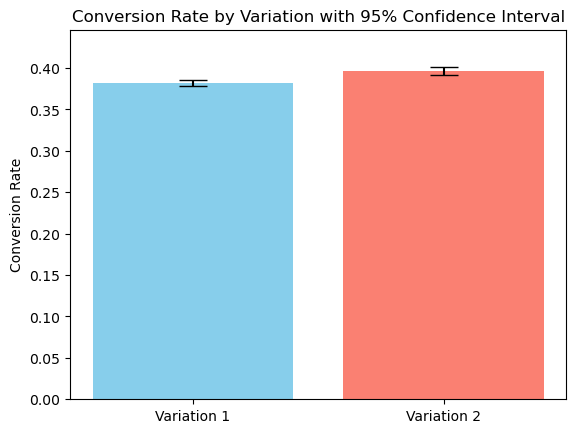

In [112]:
#visualize with a bar plot
labels = ['Variation 1', 'Variation 2']
conversions = [conversion_1, conversion_2]
errors = [[error_1[0], error_2[0]], [error_1[1], error_2[1]]] 

fig, ax = plt.subplots()
ax.bar(labels, conversions, yerr=errors, capsize=10, color=['skyblue', 'salmon'])

# Add labels and title
ax.set_ylabel('Conversion Rate')
ax.set_title('Conversion Rate by Variation with 95% Confidence Interval')
ax.set_ylim(0, max(conversions) + 0.05)
plt.show()

From the barplot, we can conclude that the increase of conversion rate on variation 2 to variation 1 is statistically significant, indicating the larger images did improve the order conversion.

We can calculate how much lift it is from variation 1 to variation 2, and visualize the increase for each hour 

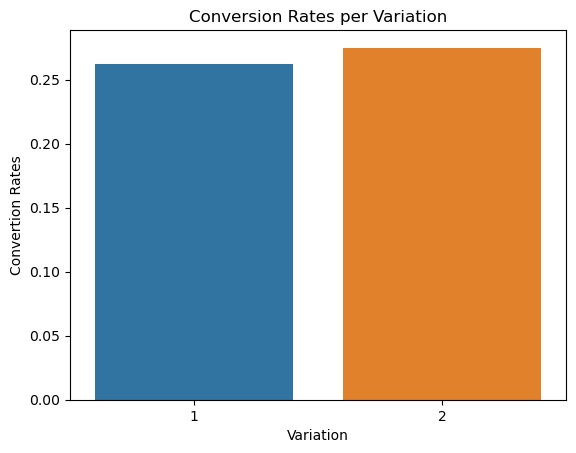

In [82]:
#group data by variation, calculate total records and conversions
group = data_1.groupby('variation').agg(
    total_record = ('event_id', 'count'),
    total_conversion = ('conversion', 'sum')
).reset_index()

group['conversion_rate'] = group['total_conversion'] / group['total_record']

#visualize the conversion rate
sns.barplot(data=group, x='variation', y='conversion_rate')
plt.title('Conversion Rates per Variation')
plt.xlabel('Variation')
plt.ylabel('Conversion Rates')
plt.show()

In [93]:
lift = group.loc[1,'conversion_rate'] / group.loc[0,'conversion_rate']

print(f"Lift: {lift:.2f}%")

Lift: 1.05%


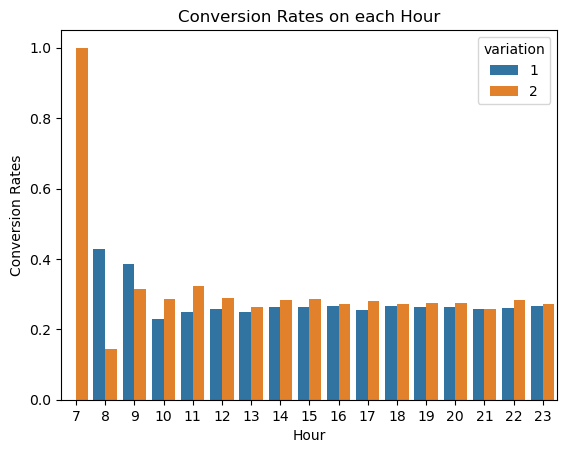

In [76]:
#group data by hour, calculate total records and conversions
group = data_1.groupby(['hour','variation']).agg(
    total_record = ('event_id', 'count'),
    total_conversion = ('conversion', 'sum')
).reset_index()

group['conversion_rate'] = group['total_conversion'] / group['total_record']

#bar plot on variation
sns.barplot(data=group, x='hour', y='conversion_rate', hue='variation',dodge=True)
plt.title('Conversion Rates on each Hour')
plt.xlabel('Hour')
plt.ylabel('Conversion Rates')
plt.show()

As shown in the plot, variation 2 has higher conversion rates than variation 1 with a 1.05% lift. From the second plot, the conversion rates for variation 2 are consistently higher across hours, except for 8 am and 9 am, but the orders on those hours are low.

## Conclusion & Recommendations

### Conclusions

#### Test Results
After aggregating results at the user level and conducting a two-proportion z-test, we found that variation 2 achieved a higher conversion rate than variation 1, The difference was statistically significant (p=0.0002), indicating that the change in image size positively impacted user behavior. The confidence interval for each variation was also checked, and it further confirm this conclusion.

#### A/B Test Evaluation
From the dataset provided for the test, there are two important points to reconsider:
1. The assignment to variation 1 and 2 was unbalanced, with variation 1 having roughly twice the records of variation 2. This can reduce statistical efficiency and introduce a potential bias especially if the imbalance was due to non-random assignment.

2. The presence of multiple impressions per user introduces dependency between observations, which violates the assumption of independent data points. This can lead to overconfident p-values. A better design would aggregate conversion at the user level or keep only one record per user. 

### Recommendations

#### A/B Testing
Based on the results of this project, we recommend implementing the enlarged images to all users to improve overall conversion rates. However, the conversion lift is only 1.04%, which is pretty small, but the dataset given is not enough to justify if the lift is meaningful or not. This would be for the product team to decide.

#### User Behavior
From the data exploration, we found that several user behavior that can be considered for business decisions:
1. User using iOS has higher conversion rate than user using Android
2. There are several shop with higher conversion rate than others with the highest being shop 5478 with 38.1% conversion rate.
3. We have peak hours from 4 pm to 8 pm, with the highest at 6 pm, where there are more orders.

Based on these user behavior, we can introduce more promotion to the iOS user to further increase the conversion rate. We can focus more on shop with higher conversion rate like putting them on the top selection when a user opens the app, to increase the traffic. We can also implement programs like peak hour promotion, to further increase the conversion rates on peak hours.